In [1]:
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython

c:\Users\dorasir\anaconda3\envs\net-simu\Lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [6]:
import numpy as np
import os
from sklearn.metrics import average_precision_score, roc_auc_score
import pandas as pd
from utils.transformation import clr
from matplotlib import pyplot as plt
from itertools import product
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from utils import simulation
import rpy2.robjects as robjects
import seaborn as sns
from utils.generalized_lotka_volterra import GeneralizedLotkaVolterra
from utils.compositional_lotka_volterra import CompositionalLotkaVolterra
from scipy.stats import ttest_rel


os.chdir('d:\\microbial_network\\microbial_network_explore')

In [3]:
n_vertices = 50
avg_degree = 5

time_points = 100
time_step = 0.01
downsample = 1
noise_var = 1e-3
scale_simulation = 100

# No noise simulation

In [4]:
network_type = 'random'
# network_type = 'small-world'

interaction_type = 'random'

adj, M = simulation.gen_graph(n_vertices, avg_degree, network_type=network_type, interaction_type=interaction_type)

In [9]:
vs = [25, 50, 100]
ds = [2, 5, 10]
ns = ['random', 'small-world', 'scale-free']

In [8]:
# score_df = pd.DataFrame(columns=['vertices', 'degree', 'type', 'mean', 'std'])
scores = []
for v, d, n in tqdm(product(vs, ds, ns)):
    adj, M = simulation.gen_graph(v, d, network_type=n, interaction_type='random')
    baseline_scores = []
    repeat = 100
    for _ in range(repeat):
        baseline = np.mean(np.dstack([np.random.uniform(0, 1, size=(v, v)) for _ in range(repeat)]), axis=2)
        baseline_score = average_precision_score(adj[~np.eye(v, dtype=bool)], baseline[~np.eye(v, dtype=bool)])
        baseline_scores.append(baseline_score)
    mu = np.mean(baseline_scores)
    sigma = np.std(baseline_scores)
    scores.append([v, d, n, mu, sigma])
score_df = pd.DataFrame(scores, columns=['vertices', 'degree', 'type', 'mean', 'std'])


27it [00:20,  1.29it/s]


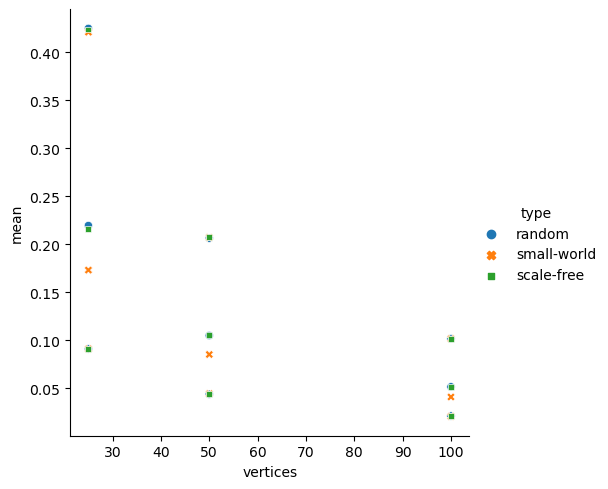

In [16]:
sns.relplot(x='vertices', y='mean', data=score_df, hue='type', style='type')

PRAUC: 0.105 +- 0.007
AUROC: 0.500 +- 0.021


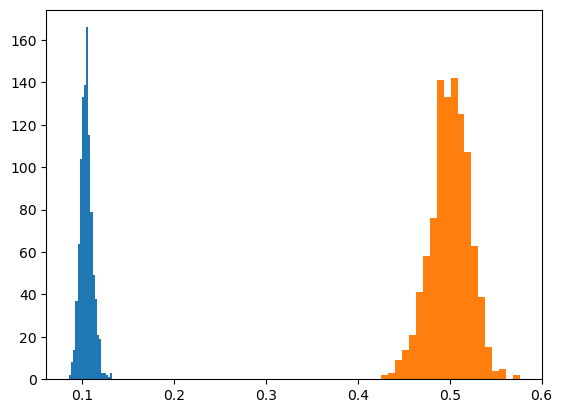

In [8]:
baseline_pr = []
baseline_auc = []
repeat = 1000
for _ in range(repeat):
    # baseline = np.mean(np.dstack([np.random.uniform(0, 1, size=(n_vertices, n_vertices)) for _ in range(repeat)]), axis=2)
    # baseline_score = average_precision_score(adj[~np.eye(n_vertices, dtype=bool)], baseline[~np.eye(n_vertices, dtype=bool)])
    # baseline_scores.append(baseline_score)
    baseline = np.random.uniform(0, 1, size=(n_vertices, n_vertices))
    baseline_pr.append(average_precision_score(adj[~np.eye(n_vertices, dtype=bool)], baseline[~np.eye(n_vertices, dtype=bool)]))
    baseline_auc.append(roc_auc_score(adj[~np.eye(n_vertices, dtype=bool)], baseline[~np.eye(n_vertices, dtype=bool)]))
n, bins, _ = plt.hist(baseline_pr, bins=20)
mu = np.mean(baseline_pr)
sigma = np.std(baseline_pr)
print(f'PRAUC: {mu:.3f} +- {sigma:.3f}')

n, bins, _ = plt.hist(baseline_auc, bins=20)
mu = np.mean(baseline_auc)
sigma = np.std(baseline_auc)
print(f'AUROC: {mu:.3f} +- {sigma:.3f}')

## Simulation result on single simulation

In [12]:
import utils.evaluations as ev
metrics = [average_precision_score, roc_auc_score]

In [11]:
# Simulate data
abd, _, _ = simulation.simulate_noiseless_glv(time_points=time_points, downsample=downsample, adj=adj, M=M)
abd_df = pd.DataFrame(abd)

R[write to console]: No methods found in package 'Brobdingnag' for request: 'sum' when loading 'untb'



In [14]:
ev.correlation_score(abd_df, adj, metrics=metrics, verbose=True)
ev.precision_matrix_score(abd_df, adj, metrics=metrics, verbose=True)

average_precision_score: 0.3020948197308429
roc_auc_score: 0.43979636363636365
average_precision_score: 0.18997026883803111
roc_auc_score: 0.5033236363636363


[0.18997026883803111, 0.5033236363636363]

In [15]:
abd_clr = pd.DataFrame(clr(abd_df))

ev.correlation_score(abd_clr, adj, metrics=metrics, verbose=True)
ev.precision_matrix_score(abd_clr, adj, metrics=metrics, verbose=True)

average_precision_score: 0.13247471028003166
roc_auc_score: 0.43224000000000007
average_precision_score: 0.09527963823992544
roc_auc_score: 0.4669236363636364


[0.09527963823992544, 0.4669236363636364]

In [23]:
ev.clv_score(abd, adj, metrics=metrics, verbose=True)
ev.glv_score(abd, adj, metrics=metrics, verbose=True)

5722.090562949743
average_precision_score: 0.11865503044946406
roc_auc_score: 0.5346242977463562
average_precision_score: 0.13892878863945846
roc_auc_score: 0.53726


[0.13892878863945846, 0.53726]

In [25]:
%%R -i abd_df -i abd
library(ppcor)
network_pred_ppea <- abs(pcor(abd_df)$estimate)
library(SpiecEasi)
network_pred_sparcc <- abs(sparcc(abd)$Cor)
network_pred_spiec <- spiec.easi(abd,method='mb')
network_pred_spiec <- as.matrix(getOptMerge(network_pred_spiec))

R[write to console]: 载入需要的程辑包：MASS

R[write to console]: 
载入程辑包：'SpiecEasi'


R[write to console]: The following object is masked from 'package:MASS':

    fitdistr


R[write to console]: The following object is masked from 'package:igraph':

    make_graph


R[write to console]: Applying data transformations...

R[write to console]: Selecting model with pulsar using stars...

R[write to console]: Fitting final estimate with mb...

R[write to console]: done



In [28]:
print('Partial Pearson')
network_pred_ppea = robjects.globalenv['network_pred_ppea']
network_pred_ppea = np.array(network_pred_ppea)
ev.calc_nondiag_score(network_pred_ppea, adj, metrics=metrics, verbose=True)

print('SparCC')
network_pred_sparcc = robjects.globalenv['network_pred_sparcc']
network_pred_sparcc = np.array(network_pred_sparcc)
ev.calc_nondiag_score(network_pred_sparcc, adj, metrics=metrics, verbose=True)

print('SpiecEasi')
network_pred_spiec = robjects.globalenv['network_pred_spiec']
network_pred_spiec = np.array(network_pred_spiec)
ev.calc_nondiag_score(network_pred_spiec, adj, metrics=metrics, verbose=True)

Partial Pearson
average_precision_score: 0.40882427318923453
roc_auc_score: 0.7319781818181819
SparCC
average_precision_score: 0.1994542526676752
roc_auc_score: 0.614181818181818
SpiecEasi
average_precision_score: 0.4731123153994576
roc_auc_score: 0.7184145454545454


[0.4731123153994576, 0.7184145454545454]

# Simulation with noise using MiSDEED

In [30]:
z, x, abd, _, _ = simulation.simulate_glv(time_points=time_points, downsample=downsample, adj=adj, M=M, noise=0.01)
abd_df = pd.DataFrame(abd)
abd_clr = pd.DataFrame(clr(abd_df))

Node 'mgx' initialized
Interaction 'mgx->mgx' added
set m:(mgx)->(mgx):   0:50    0:50
Added x0 vector to node mgx
Added growth rates to node mgx
Initialized
Interaction 'mgx_mgx' added


In [31]:
pearson_scores = ev.correlation_score(abd_df, adj, metrics=metrics, verbose=True)
precision_scores = ev.precision_matrix_score(abd_df, adj, metrics=metrics, verbose=True)
clr_pearson_scores = ev.correlation_score(abd_clr, adj, metrics=metrics, verbose=True)
clr_precision_scores = ev.precision_matrix_score(abd_clr, adj, metrics=metrics, verbose=True)
clv_scores = ev.clv_score(abd, adj, metrics=metrics, verbose=True)
glv_scores = ev.glv_score(abd, adj, metrics=metrics, verbose=True)

average_precision_score: 0.1069995803154325
roc_auc_score: 0.5169818181818182
average_precision_score: 0.10338534073583538
roc_auc_score: 0.4974109090909091
average_precision_score: 0.10610085825331075
roc_auc_score: 0.5100218181818181
average_precision_score: 0.10149929127214062
roc_auc_score: 0.5138472727272727
4.208992723014774
average_precision_score: 0.09221852425639403
roc_auc_score: 0.4725419963903929
average_precision_score: 0.09523868634988503
roc_auc_score: 0.46396


In [32]:
%%R -i abd_df -i abd
network_pred_ppea <- abs(pcor(abd_df)$estimate)
network_pred_sparcc <- abs(sparcc(abd)$Cor)
network_pred_spiec <- spiec.easi(abd,method='mb')
network_pred_spiec <- as.matrix(getOptMerge(network_pred_spiec))

R[write to console]: Applying data transformations...

R[write to console]: Selecting model with pulsar using stars...

R[write to console]: Fitting final estimate with mb...

R[write to console]: done



In [33]:
print('Partial Pearson')
network_pred_ppea = robjects.globalenv['network_pred_ppea']
network_pred_ppea = np.array(network_pred_ppea)
ev.calc_nondiag_score(network_pred_ppea, adj, metrics=metrics, verbose=True)

print('SparCC')
network_pred_sparcc = robjects.globalenv['network_pred_sparcc']
network_pred_sparcc = np.array(network_pred_sparcc)
ev.calc_nondiag_score(network_pred_sparcc, adj, metrics=metrics, verbose=True)

print('SpiecEasi')
network_pred_spiec = robjects.globalenv['network_pred_spiec']
network_pred_spiec = np.array(network_pred_spiec)
ev.calc_nondiag_score(network_pred_spiec, adj, metrics=metrics, verbose=True)

Partial Pearson
average_precision_score: 0.13727953912314617
roc_auc_score: 0.5382690909090909
SparCC
average_precision_score: 0.1015400399824623
roc_auc_score: 0.4877672727272727
SpiecEasi
average_precision_score: 0.1029167929034561
roc_auc_score: 0.5072909090909091


[0.1029167929034561, 0.5072909090909091]

In [73]:
%%R
network_pred_spiec <- spiec.easi(abd,method='glasso')
network_pred_spiec <- as.matrix(getOptMerge(network_pred_spiec))

R[write to console]: Applying data transformations...

R[write to console]: Selecting model with pulsar using stars...

R[write to console]: Fitting final estimate with glasso...

R[write to console]: done



In [74]:
network_pred_spiec = robjects.globalenv['network_pred_spiec']
network_pred_spiec = np.array(network_pred_spiec)
print(average_precision_score(adj[~np.eye(n_vertices, dtype=bool)], network_pred_spiec[~np.eye(n_vertices, dtype=bool)]))

0.41744088548999425


## Simulation result on repeated simulation

In [ ]:
# abundances = []
# abundances_df = []
# repeat = 50
# for _ in range(repeat):
#     abd, _, _ = simulation.simulate_noiseless_glv(time_points=time_points, downsample=downsample, adj=adj, M=M)
#     abundances.append(abd)
#     abundances_df.append(pd.DataFrame(abd))

# cor_scores = []
# prec_scores = []
# for i in range(repeat):
#     cor = abundances_df[i].corr().to_numpy()
#     cov = abundances_df[i].cov().to_numpy()
#     prec = np.linalg.inv(cov)

#     cor_scores.append(average_precision_score(adj.ravel(), np.abs(cor).ravel()))
#     prec_scores.append(average_precision_score(adj.ravel(), np.abs(prec).ravel()))


From the figure below for repeated experiments we can see that the score change for random samples is small, so we only present result of one sample to save time

0.411 +- 0.041
0.392 +- 0.047


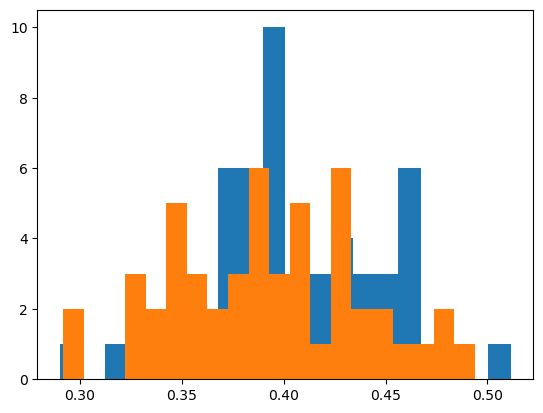

In [ ]:
# n, bins, _ = plt.hist(cor_scores, bins=20)
# mu = np.mean(cor_scores)
# sigma = np.std(cor_scores)
# print(f'{mu:.3f} +- {sigma:.3f}')
# n, bins, _ = plt.hist(prec_scores, bins=20)
# mu = np.mean(prec_scores)
# sigma = np.std(prec_scores)
# print(f'{mu:.3f} +- {sigma:.3f}')

In [ ]:
ttest_rel(cor_scores, prec_scores)

TtestResult(statistic=3.5637258011527617, pvalue=0.0008266584042734103, df=49)